In [2]:
import warnings
warnings.filterwarnings('ignore')
# import geoplot as gplt

import geopandas as gpd
# import geoplot.crs as gcrs
import imageio
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
from shapely.geometry import Point
import mapclassify as mc
import numpy as np
import laspy
import rasterio
from rasterio import mask
import folium
import plotly.offline as go_offline
import plotly.graph_objects as go

In [3]:
# read csv 
# drop all column or make new datafram with xyz
#make geodatafreme
#

In [10]:
pan = pd.read_csv('../csv/iow.csv')
pan.head()

,Classification,EdgeOfFlightLine,GpsTime,Intensity,NumberOfReturns,OriginId,PointSourceId,ReturnNumber,ScanAngleRank,ScanDirectionFlag,UserData,X,Y,Z
0,2.0,0.0,56160.044,66.0,1.0,17584.0,85.0,1.0,11.0,0.0,69.0,446171.119,4654059.969,283.56
1,2.0,0.0,56160.044,63.0,1.0,17584.0,85.0,1.0,11.0,0.0,69.0,446179.797,4654059.081,281.70
2,2.0,0.0,56160.044,64.0,1.0,17584.0,85.0,1.0,11.0,0.0,69.0,446181.543,4654058.912,281.13
3,2.0,0.0,56160.061,72.0,2.0,17584.0,85.0,2.0,11.0,1.0,69.0,446183.553,4654057.289,281.30
4,2.0,0.0,56160.061,34.0,1.0,17584.0,85.0,1.0,11.0,1.0,69.0,446176.643,4654058.001,282.68


In [17]:
def geometry (csvpath : str): 
    
    print ('===================READING CSV  =====================')
    data = pd.read_csv(csvpath)
    
    geo = data[["X","Y","Z"]]
    
    #convert xyz to geodataframe
    geometry = [Point(xy) for xy in zip(pd.to_numeric(geo['X']), pd.to_numeric(geo['Y']))]
    gdf = gpd.GeoDataFrame(geo, crs='epsg:4326',geometry=geometry)
    gdf = gdf[["Z", "geometry"]]
    gdf = gdf.rename(columns={"Z": "elevation_m", "geometry": "geometry"})
    #gdf.head()
    
    return gdf

In [18]:
csv= '../csv/iow.csv'

In [19]:
geometry(csv)

===================READING CSV  =====================


,elevation_m,geometry
0,283.56,POINT (446171.119 4654059.969)
1,281.70,POINT (446179.797 4654059.081)
2,281.13,POINT (446181.543 4654058.912)
3,281.30,POINT (446183.553 4654057.289)
4,282.68,POINT (446176.643 4654058.001)
...,...,...
1399616,273.12,POINT (447500.229 4654048.369)
1399617,273.09,POINT (447505.651 4654049.470)
1399618,273.08,POINT (447507.438 4654049.827)
1399619,273.09,POINT (447503.067 4654050.007)


In [20]:
## Plot raster/tif image
# --------------------
def plot_raster(tifile: str, title=''):
    """
    Plots raster tif image both in log scale(+1) and original verion
    """
    spr_tif = tifile
    raster_spr = rasterio.open(spr_tif)
    spr_data = raster_spr.read(1)
    fig, (axlog, axorg) = plt.subplots(1, 2, figsize=(14,7))
    im1 = axlog.imshow(np.log1p(spr_data)) # vmin=0, vmax=2.1)
#     im2 = axorg.imshow(rast_data)

    plt.title("{}".format(title), fontdict = {'fontsize': 15})  
    plt.axis('off')
    plt.colorbar(im1, fraction=0.03)

In [21]:
#count = spr_data[spr_data > 0].sum()
#count

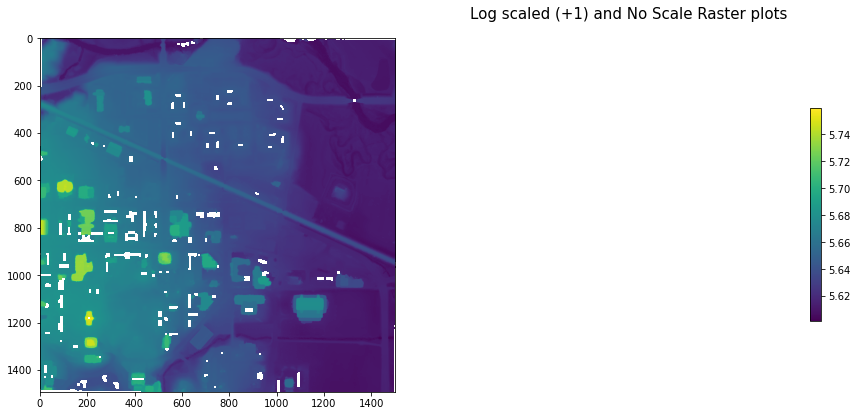

In [23]:
title = 'Log scaled (+1) and No Scale Raster plots'
plot_raster('../tif/iow.tif', title)

In [ ]:

#3D TERRAIN MODELLING
#CREATED BY: IDEAGORA GEOMATICS
#ORIGINAL SOURCE CODE AT WWW.GEODOSE.COM

import numpy as np
import plotly.offline as go_offline
import plotly.graph_objects as go


    
#DISTANCE FUNCTION
def distance(x1,y1,x2,y2):
    d=np.sqrt((x1-x2)**2+(y1-y2)**2)
    return d

#CREATING IDW FUNCTION
def idw_npoint(xz,yz,n_point,p):
    r=10 #block radius iteration distance
    nf=0
    while nf<=n_point: #will stop when np reaching at least n_point
        x_block=[]
        y_block=[]
        z_block=[]
        r +=10 # add 10 unit each iteration
        xr_min=xz-r
        xr_max=xz+r
        yr_min=yz-r
        yr_max=yz+r
        for i in range(len(x)):
            # condition to test if a point is within the block
            if ((x[i]>=xr_min and x[i]<=xr_max) and (y[i]>=yr_min and y[i]<=yr_max)):
                x_block.append(x[i])
                y_block.append(y[i])
                z_block.append(z[i])
        nf=len(x_block) #calculate number of point in the block
    
    #calculate weight based on distance and p value
    w_list=[]
    for j in range(len(x_block)):
        d=distance(xz,yz,x_block[j],y_block[j])
        if d>0:
            w=1/(d**p)
            w_list.append(w)
            z0=0
        else:
            w_list.append(0) #if meet this condition, it means d<=0, weight is set to 0
    
    #check if there is 0 in weight list
    w_check=0 in w_list
    if w_check==True:
        idx=w_list.index(0) # find index for weight=0
        z_idw=z_block[idx] # set the value to the current sample value
    else:
        wt=np.transpose(w_list)
        z_idw=np.dot(z_block,wt)/sum(w_list) # idw calculation using dot product
    return z_idw
x = pan ['X'][:1000]
y = pan ['Y'][:1000]
z = pan ['Z'][:1000]
# POPULATE INTERPOLATION POINTS
n=500 #number of interpolation point for x and y axis
x_min=min(x)
x_max=max(x)
y_min=min(y)
y_max=max(y)
w=x_max-x_min #width
h=y_max-y_min #length
wn=w/n #x interval
hn=h/n #y interval

#list to store interpolation point and elevation
y_init=y_min
x_init=x_min
x_idw_list=[]
y_idw_list=[]
z_head=[]
for i in range(n):
    xz=x_init+wn*i
    yz=y_init+hn*i
    y_idw_list.append(yz)
    x_idw_list.append(xz)
    z_idw_list=[]
    for j in range(n):
        xz=x_init+wn*j
        z_idw=idw_npoint(xz,yz,5,1.5) #min. point=5, p=1.5
        z_idw_list.append(z_idw)
    z_head.append(z_idw_list)

# CREATING 3D TERRAIN
fig=go.Figure()
fig.add_trace(go.Surface(z=z_head,x=x_idw_list,y=y_idw_list))
fig.update_layout(scene=dict(aspectratio=dict(x=2, y=2, z=0.5),xaxis = dict(range=[x_min,x_max],),yaxis = dict(range=[y_min,y_max])))
go_offline.plot(fig,filename='../3D_Terrain/3d_terrain_iowa.html',validate=True, auto_open=False)